# Introduction
Aminolevulinic acid (ALA) in an endogenous amino acid used during the heme cycle and the pre-curser to Protoporphyrin IX (PpIX). In a dermatologic setting, ALA can be topically applied to a non-melanoma skin cancer or pre-cancer and excess PpIX will be generated locally. PpIX is a photo-active compound which can be excited with blue light. When excited the PpIX will generate reactive oxygen causing localized cell death and will also emit red light. 

The images in this series show normal skin at three time-points (from left to right): before ALA application, 20 minutes after ALA application and 11 hours after ALA application. During this time frame the skin was occluded from light to allow the PpIX to develop. The fluorescence is related to the local concentration of PpIX. The final images use a log-based color scale to help show the dramatic difference in the range of values.


In [1]:
import os
import numpy
from skimage import io
from skimage.transform import rescale
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Ignore warnings so they won't be displayed
import warnings
warnings.filterwarnings('ignore')

In [2]:

filter_name = {'9':'ND',
             '8': '650-LP',
             '0': '635-BP10',
             '2': '671-BP1.5',
             '3': '685-BP10',
             '4': '695-BP10',
             '5': '710-BP20',
             '6': '727-BP5',
             '7': '811-BP20'
            }
filter_bw = ['ND', '650-LP', '635-BP10', '671-BP1.5', '685-BP10', '695-BP10', '710-BP20', '727-BP5', '811-BP20']

In [3]:
exp_date = "ALASkin"
root_path = "./" + exp_date
phantom_samples = ['Skin']
fws = ['0', '3', '4', '5', '8', '9']
colors = ["Red", "Blue", "White"]
blood_conc = ['pre','10', '20', '660']
phantom_data = {}

#Find all Phantom sub-directories
phantom_dir = os.listdir(root_path)
# Loop through each phantom sample
for phantom_name in phantom_samples:
    # Loop through each blood concentration per sample
    phantom_data[phantom_name] = {}
    for blood in blood_conc:
        #Construct root name of phantom with current blood concentration
        phantom_name_blood = '{}_{}'.format(phantom_name, blood)
        # Check is specific phantom exists
        if phantom_name_blood in phantom_dir:
            phantom_data[phantom_name][blood] = {}
            # Add that sub-directory to the path
            data_path = os.path.join(root_path, phantom_name_blood)
            # Find all files in this sub-directory
            for current_color in colors:
                phantom_data[phantom_name][blood][current_color] = {}
                
                for file in os.listdir(data_path):
                    # Find only files of the correct excitation color
                    if current_color in file:
                        split_file = file.split('_')
                        fw = split_file[3]
                        exposure = split_file[4]
                        if fw not in phantom_data[phantom_name][blood][current_color].keys():
                            # Add this entry if does not already exist
                            phantom_data[phantom_name][blood][current_color][fw] = {}
                        if '_c.tiff' in file:
                            full_file_path = os.path.join(data_path, file)
                            phantom_data[phantom_name][blood][current_color][fw]['base'] = numpy.array(io.imread(full_file_path),dtype=numpy.int16)
                        else:
                            date_stamp = split_file[5].split('.')[0]
                            full_file_path = os.path.join(data_path, file)
                            phantom_data[phantom_name][blood][current_color][fw]['raw'] = numpy.array(io.imread(full_file_path), dtype=numpy.int16)
                            phantom_data[phantom_name][blood][current_color][fw]['exposure'] = float(exposure)
                            phantom_data[phantom_name][blood][current_color][fw]['date_stamp'] = date_stamp
                        current_keys = phantom_data[phantom_name][blood][current_color][fw].keys()
                        # If the image set has been read, create and store the difference image
                        if 'base' in current_keys and 'raw' in current_keys:
                            base = phantom_data[phantom_name][blood][current_color][fw]['base']
                            raw = phantom_data[phantom_name][blood][current_color][fw]['raw']
                            diff =  (raw - base).clip(min=0)
                            phantom_data[phantom_name][blood][current_color][fw]['diff'] = diff
                        
                        
        

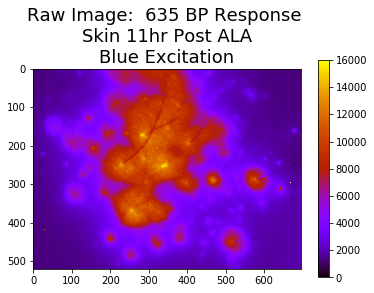

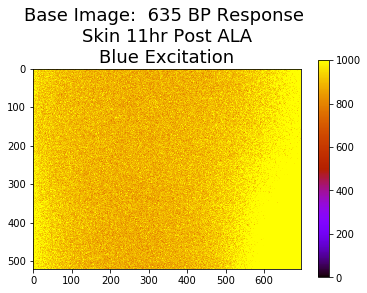

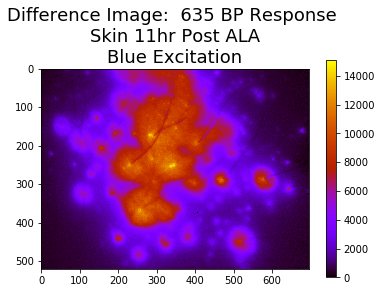

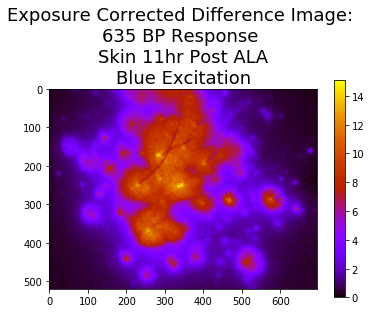

In [4]:
plt.figure()
plt.title('Raw Image:  635 BP Response \nSkin 11hr Post ALA\nBlue Excitation', size=18)
plt.imshow(phantom_data['Skin']['660']['Blue']['0']['raw'], cmap='gnuplot', interpolation='nearest', vmin=0, vmax=16000) 
plt.colorbar()
plt.show()

plt.figure()
plt.title('Base Image:  635 BP Response \nSkin 11hr Post ALA\nBlue Excitation', size=18)
plt.imshow(phantom_data['Skin']['660']['Blue']['0']['base'], cmap='gnuplot', interpolation='nearest', vmin=0, vmax=1000) 
plt.colorbar()
plt.show()


plt.figure()
plt.title('Difference Image:  635 BP Response \nSkin 11hr Post ALA\nBlue Excitation', size=18)
plt.imshow(phantom_data['Skin']['660']['Blue']['0']['diff'], cmap='gnuplot', interpolation='nearest', vmin=0) 
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Corrected Difference Image: \n635 BP Response \nSkin 11hr Post ALA\nBlue Excitation', size=18)
exposure = phantom_data['Skin']['660']['Blue']['0']['exposure']
plt.imshow(phantom_data['Skin']['660']['Blue']['0']['diff']/exposure, cmap='gnuplot', interpolation='nearest', vmin=0) 
plt.colorbar()
plt.show()



In [5]:
def display_shutter_corrected_blood_image(image_container, sample_name, color, cmap='gray', fw_nums=['0','8'], blood_concs=['pre','10', '20','660'], titles=filter_bw, add_mask=False, median_filtered=False):
        fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharex=True, sharey=True,
                             subplot_kw={'adjustable': 'box-forced'})
        fig.suptitle('Skin ({} Excitation)'.format(color), fontsize=20)
        axs = axes.ravel()
        #plt.setp(axs[0].get_xticklabels(), visible=False)
        i=0
        for blood in blood_concs:
            #v = numpy.linspace(0, 2.0, 64, endpoint=True)
            j=0
            if blood == 'pre':
                blood_title = 'Pre-ALA'
            elif blood == '10':
                blood_title = '10 minutes post-ALA'
            elif blood == '20':
                blood_title = '20 minutes post-ALA'
            elif blood == '660':
                blood_title = '11 hours post-ALA'
            else:
                blood_title = ''
            for fw in fw_nums:
                if fw in image_container[sample_name][blood][color].keys():
                    if median_filtered:
                        diff = image_container[sample_name][blood][color][fw]['med_diff']
                    else:   
                        diff = image_container[sample_name][blood][color][fw]['diff']
                    exposure = image_container[sample_name][blood][color][fw]['exposure']
                    corrected_image = diff/exposure
                    if add_mask:
                        corrected_image, idx = apply_mask(corrected_image, 250)
                        
                        roi_mean = numpy.nanmean(corrected_image[idx])
                        im_max = numpy.nanmax(corrected_image[idx])
                        title = "{} (Mean: {:0.1f})".format(titles[j], roi_mean)
                    else:
                        title = "{}".format(titles[j])
                        im_max = numpy.nanmax(corrected_image)
                    title = "{}\n{}".format(title, blood_title)
                    axs[i].set_title(title)
                    cax = axs[i].imshow(corrected_image, cmap=cmap, interpolation='nearest', vmin=0, vmax=im_max)
                    plt.colorbar(cax, ax=axs[i])
                i += 1
                j += 1


        plt.show() 

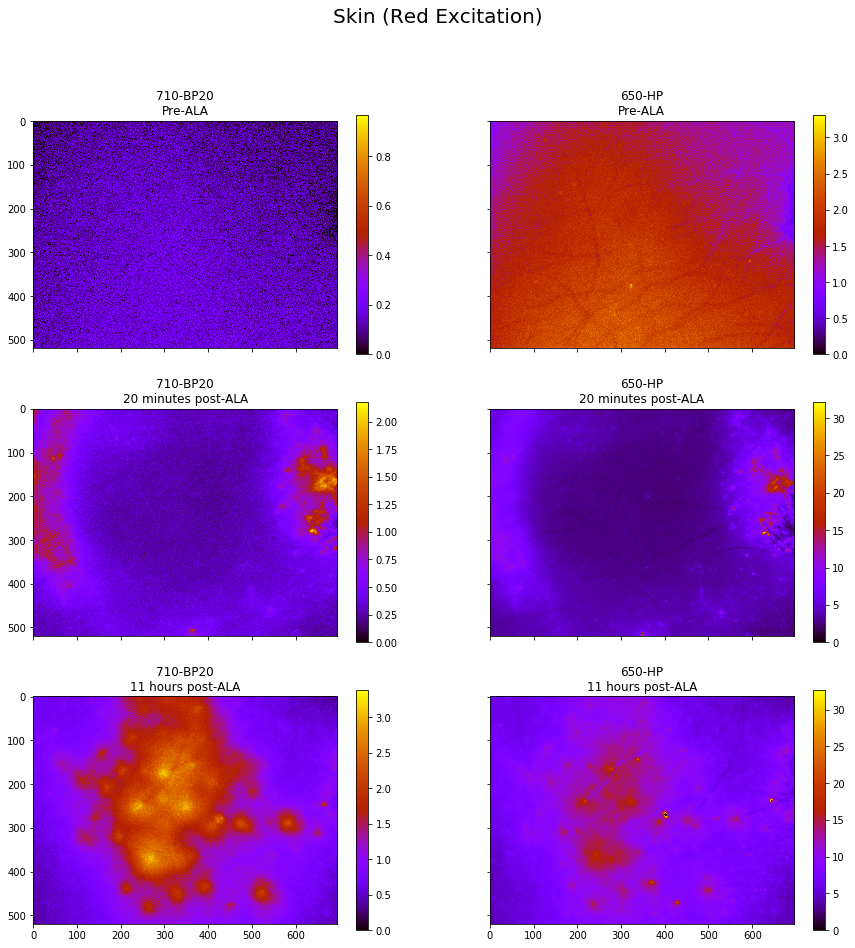

In [6]:
display_shutter_corrected_blood_image(phantom_data, 'Skin', 'Red', cmap='gnuplot', fw_nums=['5','8'], blood_concs=['pre','20','660'], titles=['710-BP20', '650-HP'], add_mask=False)

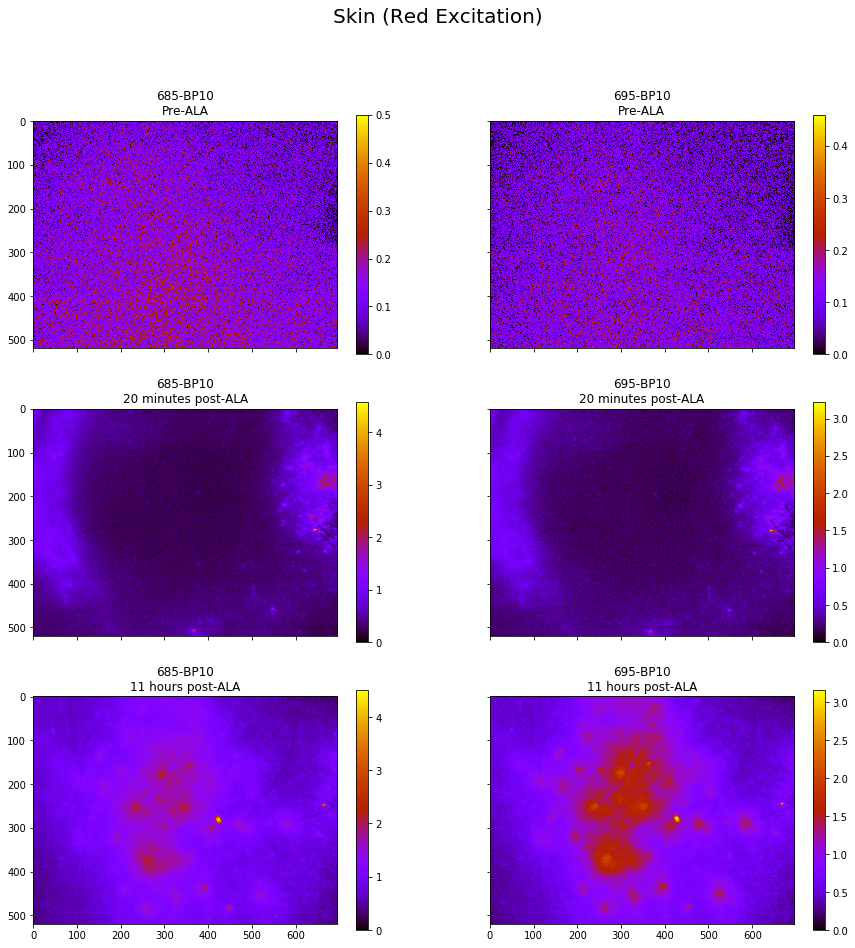

In [7]:
display_shutter_corrected_blood_image(phantom_data, 'Skin', 'Red', cmap='gnuplot', fw_nums=['3','4'], blood_concs=['pre','20','660'], titles=['685-BP10', '695-BP10'], add_mask=False
                )

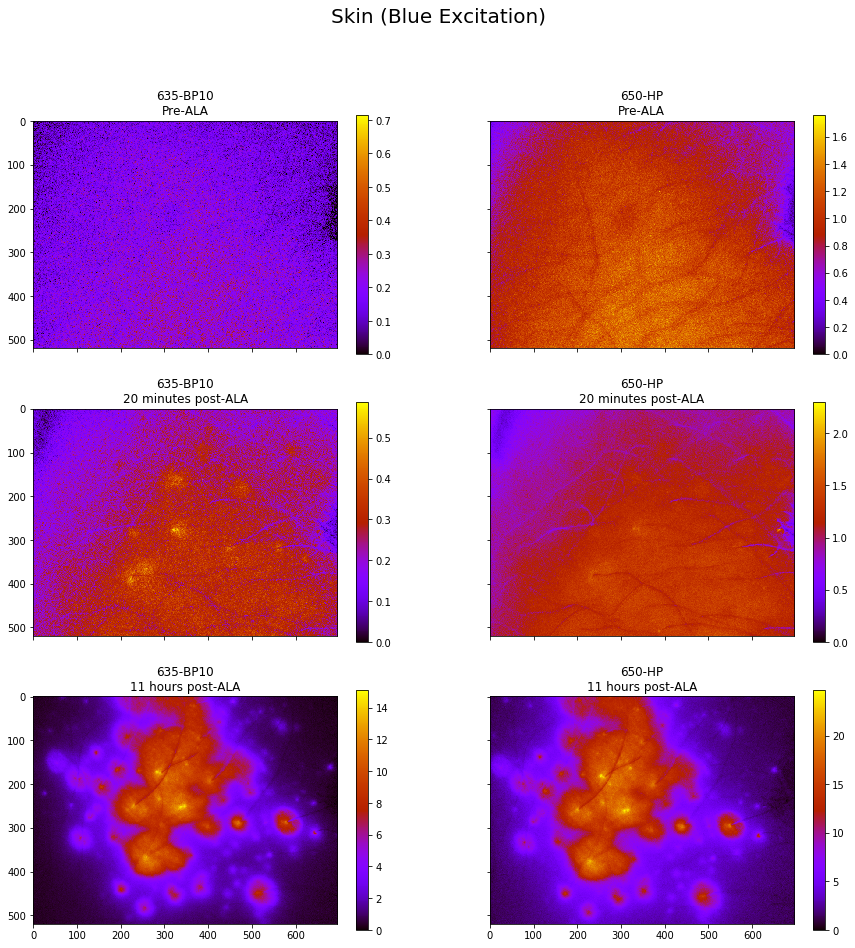

In [8]:
display_shutter_corrected_blood_image(phantom_data, 'Skin', 'Blue', cmap='gnuplot', fw_nums=['0','8'], blood_concs=['pre','20','660'], titles=['635-BP10', '650-HP'], add_mask=False)

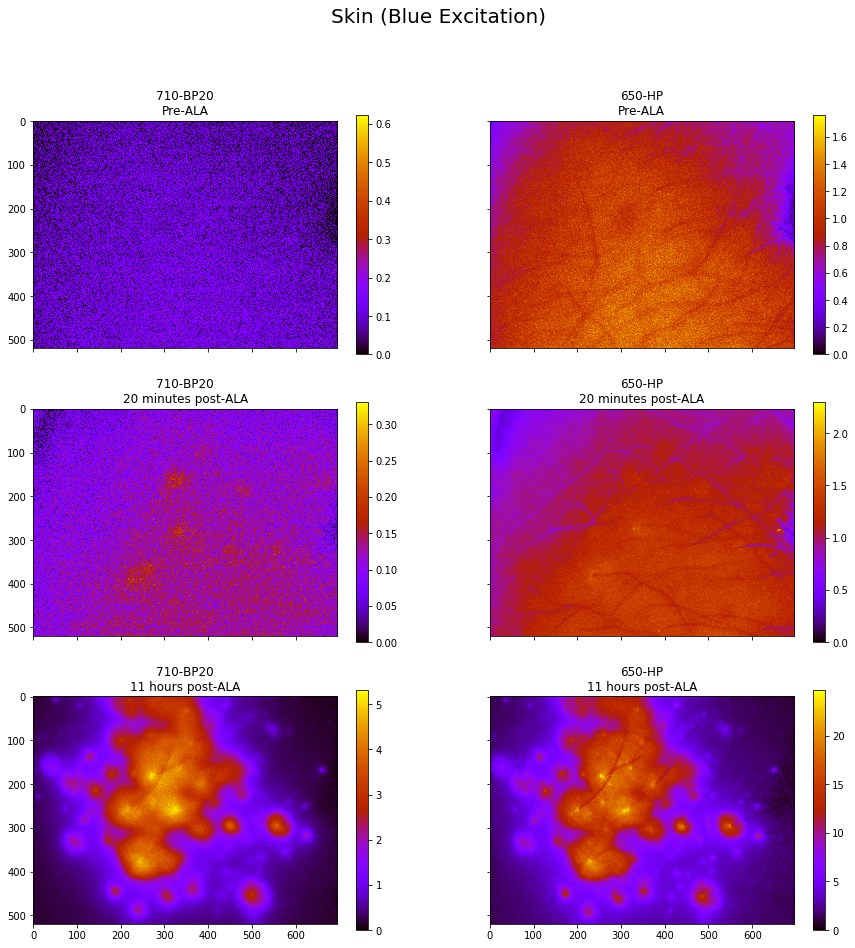

In [9]:
display_shutter_corrected_blood_image(phantom_data, 'Skin', 'Blue', cmap='gnuplot', fw_nums=['5','8'], blood_concs=['pre','20','660'], titles=['710-BP20', '650-HP'], add_mask=False)

In [10]:
# Define custom colormap that is similar to PpIX emission colors
ppix_rgb = ([0,	0,	0],
[0,	0,	0.0039],
[0,	0,	0.0078],
[0,	0,	0.0118],
[0,	0,	0.0196],
[0,	0,	0.0235],
[0,	0,	0.0275],
[0,	0,	0.0314],
[0,	0,	0.0353],
[0,	0,	0.0392],
[0,	0,	0.0431],
[0,	0,	0.0471],
[0,	0,	0.0549],
[0,	0,	0.0588],
[0,	0,	0.0627],
[0,	0,	0.0667],
[0,	0,	0.0706],
[0,	0,	0.0745],
[0,	0,	0.0784],
[0,	0,	0.0824],
[0,	0,	0.0902],
[0,	0,	0.0941],
[0,	0,	0.0980],
[0,	0,	0.1020],
[0,	0,	0.1059],
[0,	0,	0.1098],
[0,	0,	0.1137],
[0,	0,	0.1176],
[0,	0,	0.1255],
[0,	0,	0.1294],
[0,	0,	0.1333],
[0,	0,	0.1373],
[0,	0,	0.1412],
[0,	0,	0.1451],
[0,	0,	0.1490],
[0,	0,	0.1529],
[0,	0,	0.1608],
[0,	0,	0.1647],
[0,	0,	0.1686],
[0,	0,	0.1725],
[0,	0,	0.1765],
[0,	0,	0.1804],
[0,	0,	0.1843],
[0,	0,	0.1882],
[0,	0,	0.1961],
[0,	0,	0.2000],
[0,	0,	0.2039],
[0,	0,	0.2078],
[0,	0,	0.2118],
[0,	0,	0.2157],
[0,	0,	0.2196],
[0,	0,	0.2235],
[0,	0,	0.2314],
[0,	0,	0.2353],
[0,	0,	0.2392],
[0,	0,	0.2431],
[0,	0,	0.2471],
[0,	0,	0.2510],
[0,	0,	0.2549],
[0,	0,	0.2627],
[0,	0,	0.2667],
[0,	0,	0.2706],
[0,	0,	0.2745],
[0,	0,	0.2784],
[0,	0,	0.2824],
[0.0039,	0,	0.2863],
[0.0078,	0,	0.2902],
[0.0118,	0,	0.2941],
[0.0157,	0,	0.2980],
[0.0196,	0,	0.3020],
[0.0235,	0,	0.3059],
[0.0275,	0,	0.3098],
[0.0314,	0,	0.3137],
[0.0353,	0,	0.3176],
[0.0392,	0,	0.3216],
[0.0392,	0,	0.3255],
[0.0431,	0,	0.3294],
[0.0471,	0,	0.3333],
[0.0510,	0,	0.3373],
[0.0549,	0,	0.3373],
[0.0588,	0,	0.3412],
[0.0627,	0,	0.3451],
[0.0667,	0,	0.3490],
[0.0706,	0,	0.3529],
[0.0745,	0,	0.3569],
[0.0784,	0,	0.3608],
[0.0824,	0,	0.3647],
[0.0863,	0,	0.3686],
[0.0902,	0,	0.3725],
[0.0941,	0,	0.3765],
[0.0980,	0,	0.3804],
[0.0980,	0,	0.3843],
[0.1020,	0,	0.3882],
[0.1059,	0,	0.3922],
[0.1098,	0,	0.3961],
[0.1137,	0,	0.4000],
[0.1176,	0,	0.4039],
[0.1216,	0,	0.4078],
[0.1255,	0,	0.4118],
[0.1294,	0,	0.4157],
[0.1333,	0,	0.4196],
[0.1373,	0,	0.4235],
[0.1412,	0,	0.4235],
[0.1451,	0,	0.4275],
[0.1490,	0,	0.4314],
[0.1529,	0,	0.4353],
[0.1529,	0,	0.4392],
[0.1569,	0,	0.4431],
[0.1608,	0,	0.4471],
[0.1647,	0,	0.4510],
[0.1686,	0,	0.4549],
[0.1725,	0,	0.4588],
[0.1765,	0,	0.4627],
[0.1804,	0,	0.4667],
[0.1843,	0,	0.4706],
[0.1882,	0,	0.4745],
[0.1922,	0,	0.4784],
[0.1961,	0,	0.4824],
[0.2000,	0,	0.4863],
[0.2039,	0,	0.4902],
[0.2039,	0,	0.4941],
[0.2078,	0,	0.4980],
[0.2118,	0,	0.5020],
[0.2157,	0,	0.5059],
[0.2196,	0,	0.5098],
[0.2235,	0,	0.5137],
[0.2275,	0,	0.5137],
[0.2314,	0,	0.5176],
[0.2353,	0,	0.5216],
[0.2392,	0,	0.5255],
[0.2431,	0,	0.5294],
[0.2471,	0,	0.5333],
[0.2510,	0,	0.5373],
[0.2549,	0,	0.5412],
[0.2588,	0,	0.5451],
[0.2627,	0,	0.5490],
[0.2667,	0,	0.5529],
[0.2706,	0,	0.5569],
[0.2745,	0,	0.5608],
[0.2784,	0,	0.5647],
[0.2863,	0,	0.5686],
[0.2902,	0,	0.5725],
[0.2941,	0,	0.5765],
[0.2980,	0,	0.5804],
[0.3020,	0,	0.5843],
[0.3059,	0,	0.5843],
[0.3098,	0,	0.5882],
[0.3137,	0,	0.5922],
[0.3176,	0,	0.5961],
[0.3216,	0,	0.6000],
[0.3255,	0,	0.6039],
[0.3294,	0,	0.6078],
[0.3333,	0,	0.6118],
[0.3373,	0,	0.6157],
[0.3412,	0,	0.6196],
[0.3451,	0,	0.6235],
[0.3490,	0,	0.6275],
[0.3529,	0,	0.6314],
[0.3569,	0,	0.6353],
[0.3608,	0,	0.6392],
[0.3647,	0,	0.6431],
[0.3686,	0,	0.6471],
[0.3725,	0,	0.6510],
[0.3804,	0,	0.6510],
[0.3843,	0,	0.6549],
[0.3882,	0,	0.6588],
[0.3922,	0,	0.6627],
[0.3961,	0,	0.6667],
[0.4000,	0,	0.6706],
[0.4039,	0,	0.6745],
[0.4078,	0,	0.6784],
[0.4118,	0,	0.6824],
[0.4157,	0,	0.6863],
[0.4196,	0,	0.6902],
[0.4235,	0,	0.6941],
[0.4275,	0,	0.6980],
[0.4314,	0,	0.7020],
[0.4353,	0,	0.7059],
[0.4392,	0,	0.7098],
[0.4431,	0,	0.7137],
[0.4471,	0,	0.7176],
[0.4510,	0,	0.7176],
[0.4549,	0,	0.7216],
[0.4588,	0,	0.7255],
[0.4627,	0,	0.7294],
[0.4667,	0,	0.7333],
[0.4706,	0,	0.7373],
[0.4784,	0,	0.7412],
[0.4824,	0,	0.7451],
[0.4863,	0,	0.7490],
[0.4902,	0,	0.7529],
[0.4941,	0,	0.7569],
[0.4980,	0,	0.7569],
[0.5098,	0,	0.7569],
[0.5176,	0,	0.7569],
[0.5255,	0,	0.7569],
[0.5333,	0,	0.7569],
[0.5412,	0,	0.7569],
[0.5490,	0,	0.7569],
[0.5569,	0,	0.7569],
[0.5647,	0,	0.7569],
[0.5725,	0,	0.7569],
[0.5804,	0,	0.7569],
[0.5882,	0,	0.7569],
[0.5961,	0,	0.7569],
[0.6039,	0,	0.7569],
[0.6118,	0,	0.7569],
[0.6196,	0,	0.7569],
[0.6275,	0,	0.7569],
[0.6353,	0,	0.7569],
[0.6431,	0,	0.7569],
[0.6510,	0,	0.7569],
[0.6588,	0,	0.7569],
[0.6667,	0,	0.7569],
[0.6745,	0,	0.7569],
[0.6824,	0,	0.7569],
[0.6902,	0,	0.7569],
[0.6980,	0,	0.7569],
[0.7059,	0,	0.7569],
[0.7137,	0,	0.7569],
[0.7255,	0,	0.7569],
[0.7333,	0,	0.7569],
[0.7412,	0,	0.7569],
[0.7490,	0,	0.7569],
[0.7569,	0,	0.7569],
[0.7647,	0,	0.7569],
[0.7725,	0,	0.7569],
[0.7804,	0,	0.7569],
[0.7882,	0,	0.7569],
[0.7961,	0,	0.7569],
[0.8039,	0,	0.7569],
[0.8118,	0,	0.7569],
[0.8196,	0,	0.7569],
[0.8275,	0,	0.7569],
[0.8353,	0,	0.7569],
[0.8431,	0,	0.7569],
[0.8510,	0,	0.7569],
[0.8588,	0,	0.7569],
[0.8667,	0,	0.7569],
[0.8745,	0,	0.7569],
[0.8824,	0,	0.7569],
[0.8902,	0,	0.7569],
[0.8980,	0,	0.7569],
[0.9059,	0,	0.7569],
[0.9137,	0,	0.7569],
[0.9216,	0,	0.7569],
[0.9294,	0,	0.7569],
[0.9373,	0,	0.7569],
[0.9490,	0,	0.7569],
[0.9569,	0,	0.7569],
[0.9647,	0,	0.7569],
[0.9725,	0,	0.7569],
[0.9804,	0,	0.7569],
[0.9882,	0,	0.7569],
[0.9961,	0,	0.7569],
[1.0000,	0,	0.7569])
custom_ppix = matplotlib.colors.ListedColormap(ppix_rgb, name='ppix')

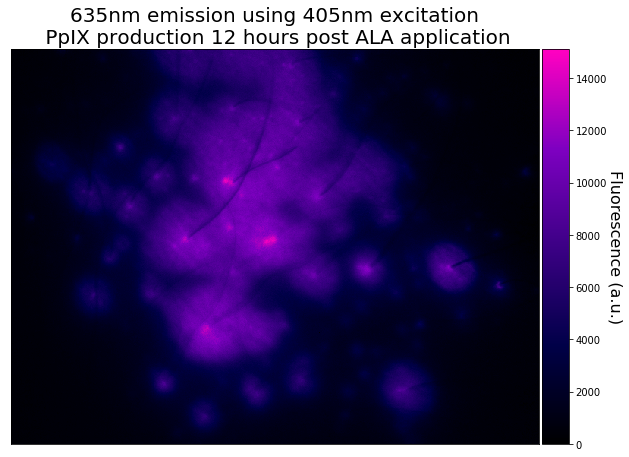

In [11]:
color_map = custom_ppix
plt.figure(figsize=(10,8))
fig = plt.imshow(phantom_data['Skin']['660']['Blue']['0']['diff'], cmap=color_map)
plt.title('635nm emission using 405nm excitation\n PpIX production 12 hours post ALA application', size=20)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.set_label('Fluorescence (a.u.)\n', rotation=270, size=16, labelpad=15)
plt.savefig('PpIX_405_635Fl_w_title.png')
plt.show()

In [12]:
pre_im = phantom_data['Skin']['pre']['Blue']['0']['diff'].astype(float)
post_20min_im = phantom_data['Skin']['20']['Blue']['0']['diff'].astype(float)
post_11hr_im = phantom_data['Skin']['660']['Blue']['0']['diff'].astype(float)

In [13]:
pre_exposure = phantom_data['Skin']['pre']['Blue']['0']['exposure']/1000
post_20min_exposure = phantom_data['Skin']['20']['Blue']['0']['exposure']/1000
post_11hr_exposure = phantom_data['Skin']['660']['Blue']['0']['exposure']/1000

In [14]:
pre_im_exp = pre_im/pre_exposure 
post_20min_im_exp = post_20min_im/post_20min_exposure
post_11hr_im_exp = post_11hr_im/post_11hr_exposure

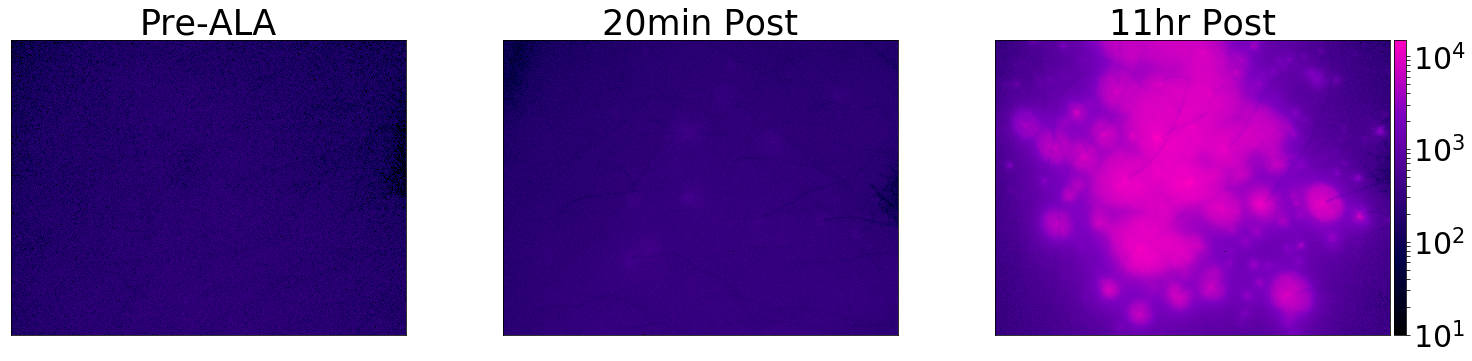

In [16]:
upper_lim = numpy.nanmax(post_11hr_im_exp)
fig = plt.subplots(1,3,figsize=(25,20))
ax1 = plt.subplot2grid((1,3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))
pre_im_ax = ax1.imshow(pre_im_exp.clip(10), cmap=color_map, vmin=10, vmax=upper_lim, norm=matplotlib.colors.LogNorm())
post20m_im_ax = ax2.imshow(post_20min_im_exp.clip(10), cmap=color_map, vmin=10, vmax=upper_lim, norm=matplotlib.colors.LogNorm())
post11h_im_ax = ax3.imshow(post_11hr_im_exp.clip(10), cmap=color_map, vmin=10, vmax=upper_lim, norm=matplotlib.colors.LogNorm())

ax1.set_title('Pre-ALA', size=35)
ax2.set_title('20min Post', size=35)
ax3.set_title('11hr Post', size=35)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax_divider = make_axes_locatable(ax1)
ax_cbar_ax = ax_divider.append_axes("right", size="3%", pad=0.05)
ax_cbar_ax.set_visible(False)
ax_divider = make_axes_locatable(ax2)
ax_cbar_ax = ax_divider.append_axes("right", size="3%", pad=0.05)
ax_cbar_ax.set_visible(False)
ax_divider = make_axes_locatable(ax3)
ax_cbar_ax = ax_divider.append_axes("right", size="3%", pad=0.05)
ax_cbar = plt.colorbar(post11h_im_ax, cax=ax_cbar_ax)
ax_cbar_ax.tick_params(labelsize=30)
plt.show()

In [17]:
pre_im_exp_big = rescale(pre_im_exp,5)
post_20min_im_exp_big = rescale(post_20min_im_exp,5)
post_11hr_im_exp_big = rescale(post_11hr_im_exp,5)

In [20]:
im_shape = numpy.shape(pre_im_exp_big)
ny = im_shape[0]
nx = im_shape[1]
padding = 250
im_holder = numpy.zeros([ny+2*padding, 3*nx+4*padding])

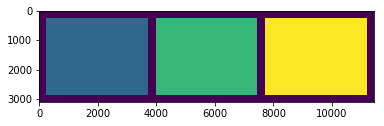

In [21]:
im_holder[padding:ny+padding,padding:nx+padding] = 1
im_holder[padding:ny+padding,nx+2*padding:2*nx+2*padding]=2
im_holder[padding:ny+padding,2*nx+3*padding:3*nx+3*padding]=3
plt.imshow(im_holder)
plt.show()

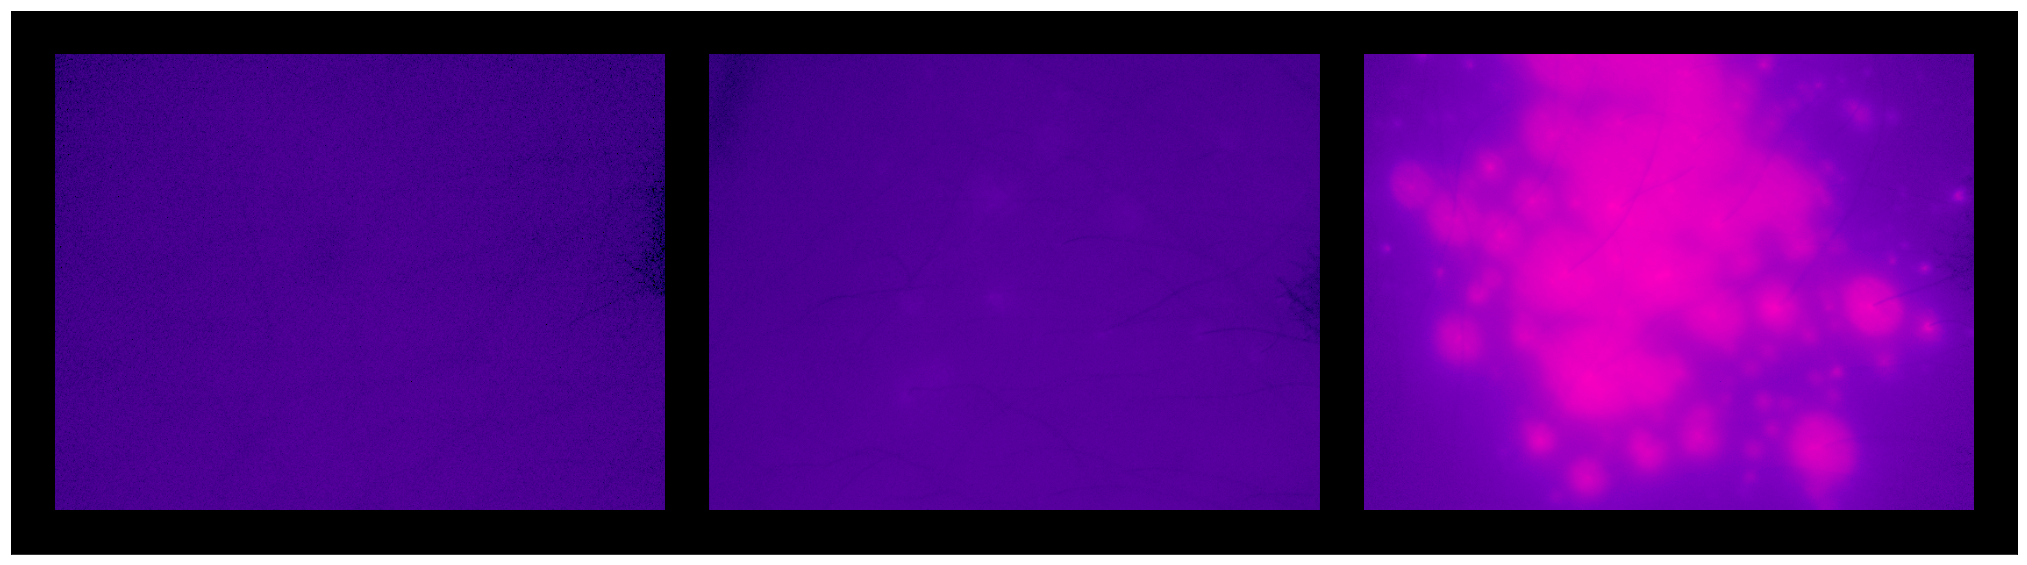

In [22]:
im_holder[padding:ny+padding,padding:nx+padding] = pre_im_exp_big
im_holder[padding:ny+padding,nx+2*padding:2*nx+2*padding] = post_20min_im_exp_big
im_holder[padding:ny+padding,2*nx+3*padding:3*nx+3*padding] = post_11hr_im_exp_big
fig = plt.figure(figsize=(40,10))
ax = plt.gca()
plt.imshow(im_holder.clip(1), cmap=color_map, vmin=1, vmax=upper_lim, norm=matplotlib.colors.LogNorm())
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('PpIX_405_635Fl.png', bbox_inches='tight')
plt.show()